In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing

In [9]:
next_station_dict = { 
    'Xavier Hall': 'Fine Arts Annex',
    'Fine Arts Annex': 'Loyola House of Studies',
    'Loyola House of Studies': 'Grade School',
    'Grade School': 'Gate 2.5',
    'Gate 2.5': 'Leong Hall',
    'Leong Hall': 'Xavier Hall'
}

In [12]:
df = pd.read_csv('Out.csv')
df = df.drop(columns=['Unnamed: 0', 'Datetime'])

df.dtypes

Altitude                                    float64
Humidity                                    float64
Temperature                                 float64
Time                                         object
Day                                         float64
Hour_of_Day                                 float64
IsEJeep1                                      int64
IsEJeep2                                      int64
IsEJeep3                                      int64
Latitude                                    float64
Longitude                                   float64
Lat Diff                                    float64
Long Diff                                   float64
Distance                                    float64
IsStation                                     int64
IsCharging                                    int64
Cum Distance                                float64
Next Station Lat                            float64
Next Station Long                           float64
Abs Distance

In [13]:
# Convert all the times into a timestamp with 0 = 00:00:00 and 86399 = 23:59:59

def time_to_daytimestamp(stamp: str) -> int:
    if stamp is None:
        return -1
    
    if isinstance(stamp, float):
        return -1
    
    h, m, s = stamp.split(':')
    return int(h) * 24 * 60 + int(m) * 60 + int(s)

df['Time'] = df['Time'].apply(lambda time: time_to_daytimestamp(time))

df['Previous Time to Xavier Hall'] = df['Previous Time to Xavier Hall'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Fine Arts Annex'] = df['Previous Time to Fine Arts Annex'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Loyola House of Studies'] = df['Previous Time to Loyola House of Studies'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Grade School'] = df['Previous Time to Grade School'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Gate 2.5'] = df['Previous Time to Gate 2.5'].apply(lambda time: time_to_daytimestamp(time))
df['Previous Time to Leong Hall'] = df['Previous Time to Leong Hall'].apply(lambda time: time_to_daytimestamp(time))

df['Next Time to Xavier Hall'] = df['Next Time to Xavier Hall'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Fine Arts Annex'] = df['Next Time to Fine Arts Annex'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Loyola House of Studies'] = df['Next Time to Loyola House of Studies'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Grade School'] = df['Next Time to Grade School'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Gate 2.5'] = df['Next Time to Gate 2.5'].apply(lambda time: time_to_daytimestamp(time))
df['Next Time to Leong Hall'] = df['Next Time to Leong Hall'].apply(lambda time: time_to_daytimestamp(time))

df

,Altitude,Humidity,Temperature,Time,Day,Hour_of_Day,IsEJeep1,IsEJeep2,IsEJeep3,Latitude,...,Next Time to Xavier Hall,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall,Encoded Day,Encoded Station,Encoded Prev Station,Encoded Next Station
0,79.0,82.500000,29.299999,25239,23.0,17.0,1,0,0,14.636047,...,9393,11123,25942,26309,25470,25778,1,8,8,1
1,78.7,82.500000,29.299999,25240,23.0,17.0,1,0,0,14.636049,...,9393,11123,25942,26309,26556,25778,1,0,8,1
2,78.4,82.500000,29.299999,25241,23.0,17.0,1,0,0,14.636050,...,9393,11123,25942,26309,26556,25778,1,0,8,1
3,78.0,82.500000,29.299999,25242,23.0,17.0,1,0,0,14.636052,...,9393,11123,25942,26309,26556,25778,1,0,8,1
4,77.7,82.500000,29.299999,25243,23.0,17.0,1,0,0,14.636055,...,9393,11123,25942,26309,26556,25778,1,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482694,75.1,80.400002,30.799999,16163,12.0,9.0,0,1,0,14.638046,...,-1,-1,-1,-1,-1,-1,7,5,4,5
482695,75.5,80.400002,30.799999,16164,12.0,9.0,0,1,0,14.638012,...,-1,-1,-1,-1,-1,-1,7,5,4,5
482696,75.3,80.400002,30.799999,16165,12.0,9.0,0,1,0,14.637973,...,-1,-1,-1,-1,-1,-1,7,5,4,5
482697,74.9,80.400002,30.799999,16166,12.0,9.0,0,1,0,14.637933,...,-1,-1,-1,-1,-1,-1,7,5,4,5


In [14]:
df = df.fillna(-1)
df

df.to_csv('Updated Out.csv')

In [15]:
X = df.copy()
X_train = X[:300_000]
X_test = X[300_001:]

# Xs is X but without the next time columns within it
Xs_train = X_train.copy()
Xs_test = X_test.copy()

Xs_train = Xs_train.drop(columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])
Xs_test = Xs_test.drop(columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])

Y_train = X_train.copy()
Y_test = X_test.copy()

Y_train = Y_train[['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3']]
Y_train = Y_train.dropna()

Y_test = Y_test[['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall', 'IsEJeep1', 'IsEJeep2', 'IsEJeep3']]
Y_test = Y_test.dropna()

assert(len(X_train) == len(Y_train))
assert(len(X_test) == len(Y_test))

In [18]:
## Use Xs instead of X, remove next time in X

X_train = Xs_train
X_test = Xs_test

## Remove isEJeep_num in Y

Y_train = Y_train.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])
Y_test = Y_test.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])

assert(len(X_train) == len(Y_train))
assert(len(X_test) == len(Y_test))

# XGBoost Regression

In [70]:
from xgboost import XGBRegressor

# xgb objective rmse
model_xgb = XGBRegressor(objective='reg:squarederror')
model_xgb.fit(X_train, Y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [69]:
### Not working
%%script echo skipping

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

# hyperparamters gird search
model_xgb = XGBRegressor(objective='reg:squarederror')
params = {'n_estimators': [100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2]}
grid = GridSearchCV(estimator=model_xgb, param_grid=params, scoring='neg_mean_squared_error', cv=4, verbose=1)
grid.fit(X_train, Y_train)
print("Best parameters found: ", grid.best_params_)
print("Lowest RMSE found: ", np.sqrt(np.abs(grid.best_score_)))



# model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05)
# model_xgb.fit(X_train, Y_train)

# xgb objective rmse
# model_xgb = XGBRegressor(objective='reg:squarederror')
# model_xgb.fit(X_train, Y_train)

# Predict the model 
# pred = model_xgb.predict(X_test)
# # put column labels on prediction
# pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])


# rmse = np.sqrt(MSE(Y_test, pred))
# print(rmse)


Fitting 4 folds for each of 9 candidates, totalling 36 fits


KeyboardInterrupt: 

In [ ]:

# xgb based on the best params
model_xgb = XGBRegressor(objective='reg:squarederror', max_depth=grid_result.best_params_['max_depth'], n_estimators=grid_result.best_params_['n_estimators'])

In [71]:
# Predict the model 
pred = model_xgb.predict(X_test)
# put column labels on prediction
pred = pd.DataFrame(data=pred, columns=['Next Time to Fine Arts Annex', 'Next Time to Loyola House of Studies', 'Next Time to Grade School', 'Next Time to Gate 2.5', 'Next Time to Leong Hall', 'Next Time to Xavier Hall'])

In [24]:
from sklearn.metrics import mean_squared_error as MSE 
  
# Metrics Computation 
rmse = np.sqrt(MSE(Y_test, pred))
r2 = r2_score(Y_test, pred)
mae = mean_absolute_error(Y_test, pred)

print("XGBoost Regression") 
print("RMSE : % f" %(rmse)) 
print("R^2 : % f" %(r2))
print("MAE : % f" %(mae))

XGBoost Regression
RMSE :  3323.182219
R^2 :  0.650806
MAE :  1970.449238


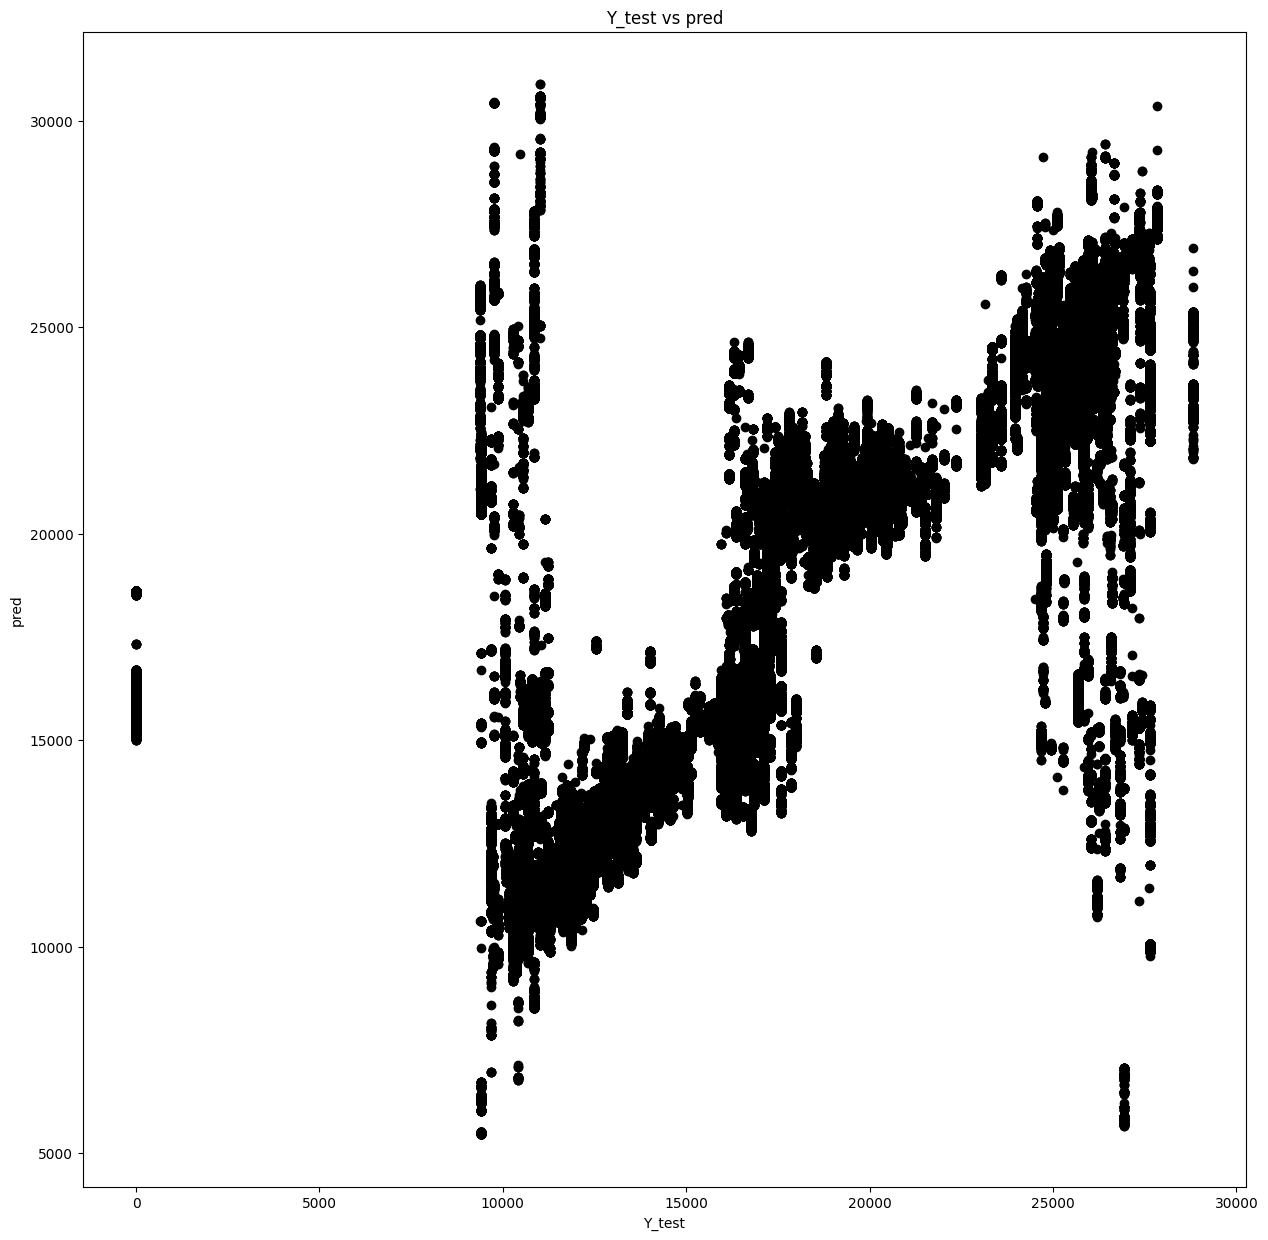

In [35]:
# plot Y_test vs pred
# make color change depending on how close the prediction to the actial value
plt.figure(figsize=(15, 15))
plt.plot(Y_test, pred, 'o', color='black')
plt.xlabel('Y_test')
plt.ylabel('pred')
plt.title('Y_test vs pred')
plt.show()

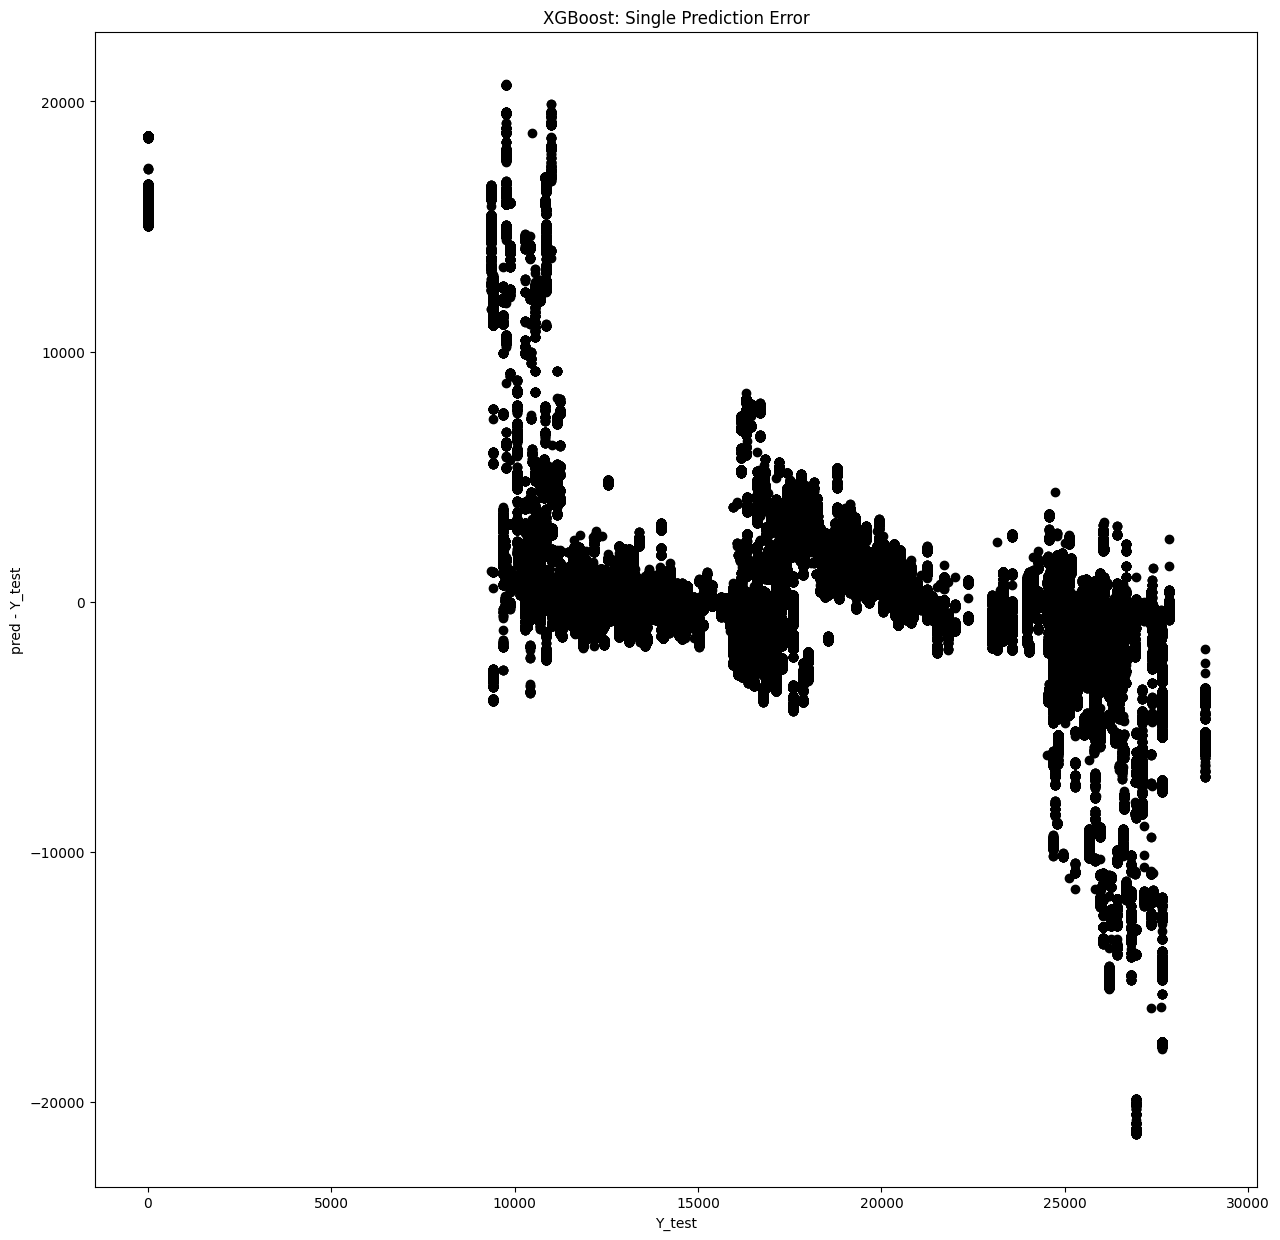

In [60]:
# plot how close the prediction to the actual value
plt.figure(figsize=(15, 15))
plt.plot(Y_test, pred.subtract(Y_test.reset_index(drop=True)), 'o', color='black')
plt.xlabel('Y_test')
plt.ylabel('pred - Y_test')
plt.title('XGBoost: Single Prediction Error')
plt.show()

<Figure size 1500x1500 with 0 Axes>

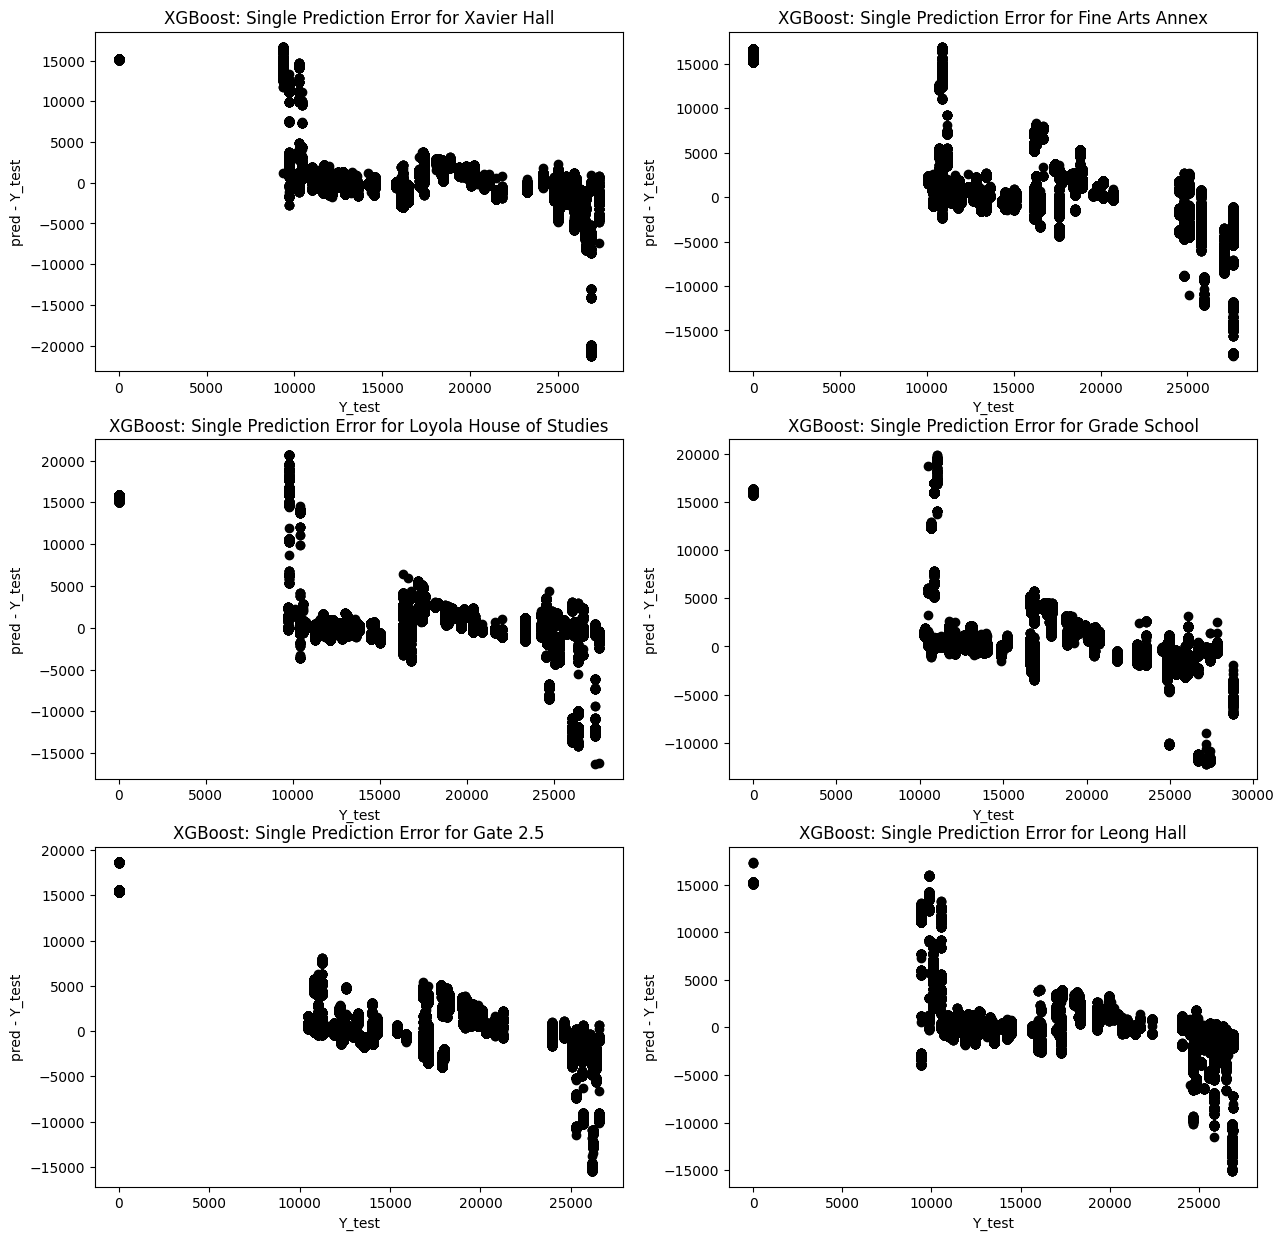

In [63]:
# plot how close the prediction to the actual value
plt.figure(figsize=(15, 15))
# plt.plot(Y_test['Next Time to Leong Hall'], pred.subtract(Y_test.reset_index(drop=True))['Next Time to Leong Hall'], 'o', color='black')
# plt.xlabel('Y_test')
# plt.ylabel('pred - Y_test')
# plt.title('XGBoost: Single Prediction Error')
# plt.show()

# make a 3x2 graph
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
# go through all stations
for i, station in enumerate(next_station_dict.keys()):
    # plot how close the prediction to the actual value
    axs[i//2, i%2].plot(Y_test[f'Next Time to {station}'], pred.subtract(Y_test.reset_index(drop=True))[f'Next Time to {station}'], 'o', color='black')
    axs[i//2, i%2].set_xlabel('Y_test')
    axs[i//2, i%2].set_ylabel('pred - Y_test')
    axs[i//2, i%2].set_title(f'XGBoost: Single Prediction Error for {station}')

In [73]:
model_xgb.save_model('xgb.model')

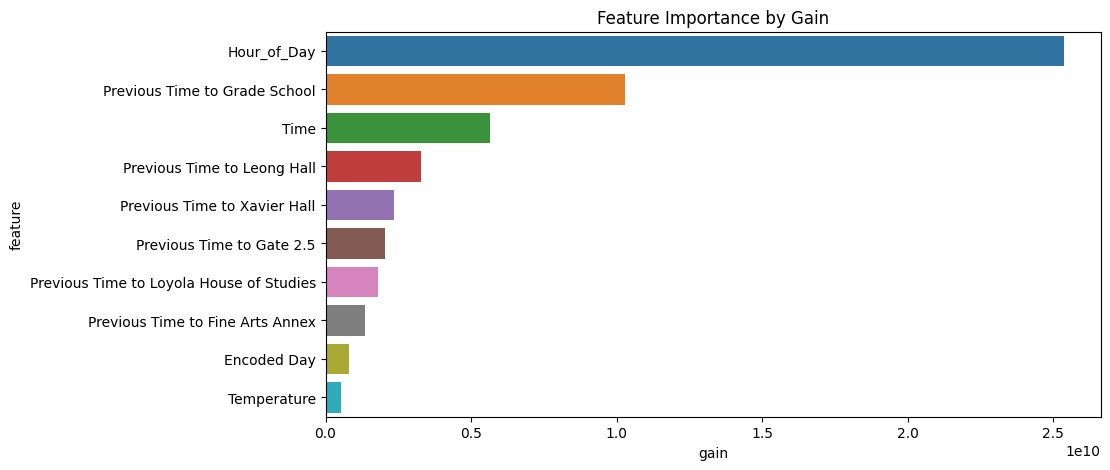

In [90]:
f_importance_gain = model_xgb.get_booster().get_score(importance_type='gain')
#sort the dictionary
f_importance_gain = sorted(f_importance_gain.items(), key=lambda x:x[1], reverse=True)
f_importance_gain
#plot top 10 features
df_gain = pd.DataFrame(f_importance_gain[:10], columns=['feature', 'gain'])
plt.figure(figsize=(10, 5))
sns.barplot(x='gain', y='feature', data=df_gain)
plt.title('Feature Importance by Gain')
plt.show()


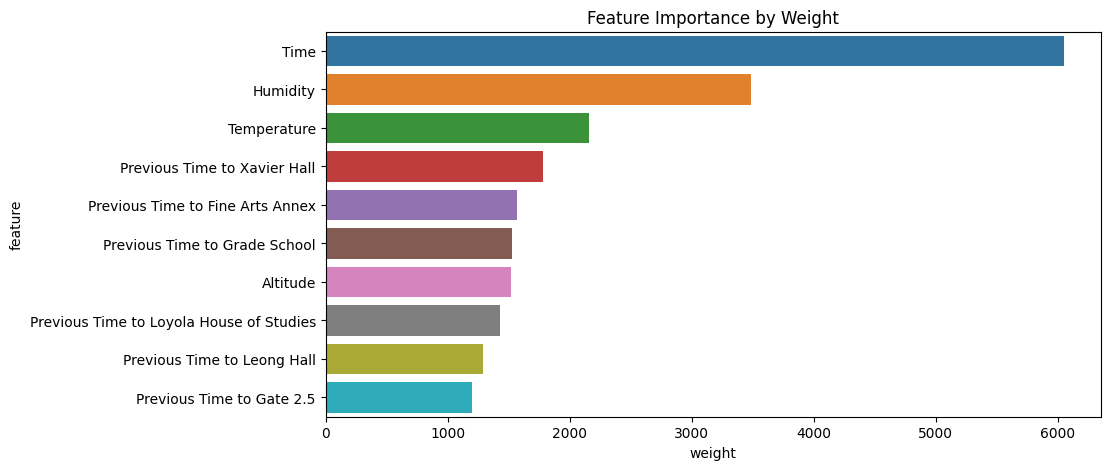

In [93]:
f_importance_weight = model_xgb.get_booster().get_score(importance_type='weight')
#sort the dictionary
f_importance_weight = sorted(f_importance_weight.items(), key=lambda x:x[1], reverse=True)
f_importance_weight
df_weight = pd.DataFrame(f_importance_weight[:10], columns=['feature', 'weight'])
plt.figure(figsize=(10, 5))
sns.barplot(x='weight', y='feature', data=df_weight)
plt.title('Feature Importance by Weight')
plt.show()


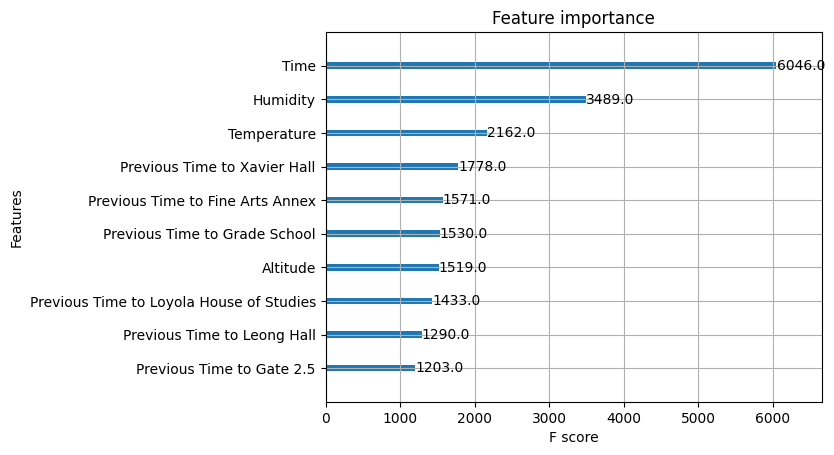

In [83]:
# XGB plot top 10 important features
from xgboost import plot_importance
plot_importance(model_xgb, max_num_features=10)
plt.show()


In [82]:
f_importance

[('Hour_of_Day', 25357438976.0),
 ('Previous Time to Grade School', 10302603264.0),
 ('Time', 5639560704.0),
 ('Previous Time to Leong Hall', 3269698048.0),
 ('Previous Time to Xavier Hall', 2366578176.0),
 ('Previous Time to Gate 2.5', 2057475456.0),
 ('Previous Time to Loyola House of Studies', 1788935040.0),
 ('Previous Time to Fine Arts Annex', 1363453952.0),
 ('Encoded Day', 820600384.0),
 ('Temperature', 542846336.0),
 ('Humidity', 471048960.0),
 ('Day', 446977984.0),
 ('Next Station Lat', 341612832.0),
 ('Encoded Station', 298175104.0),
 ('Prev Cum Distance', 111370336.0),
 ('Latitude', 107096768.0),
 ('IsEJeep1', 94122736.0),
 ('Prev Station Lat', 92570648.0),
 ('Prev Station Long', 89937280.0),
 ('Next Station Long', 78275792.0),
 ('Abs Distance', 74425832.0),
 ('Prev Abs Distance', 71785672.0),
 ('Longitude', 71494160.0),
 ('Encoded Next Station', 61744488.0),
 ('Cum Distance', 46156688.0),
 ('Encoded Prev Station', 27721226.0),
 ('Altitude', 24385292.0),
 ('IsStation', 41067

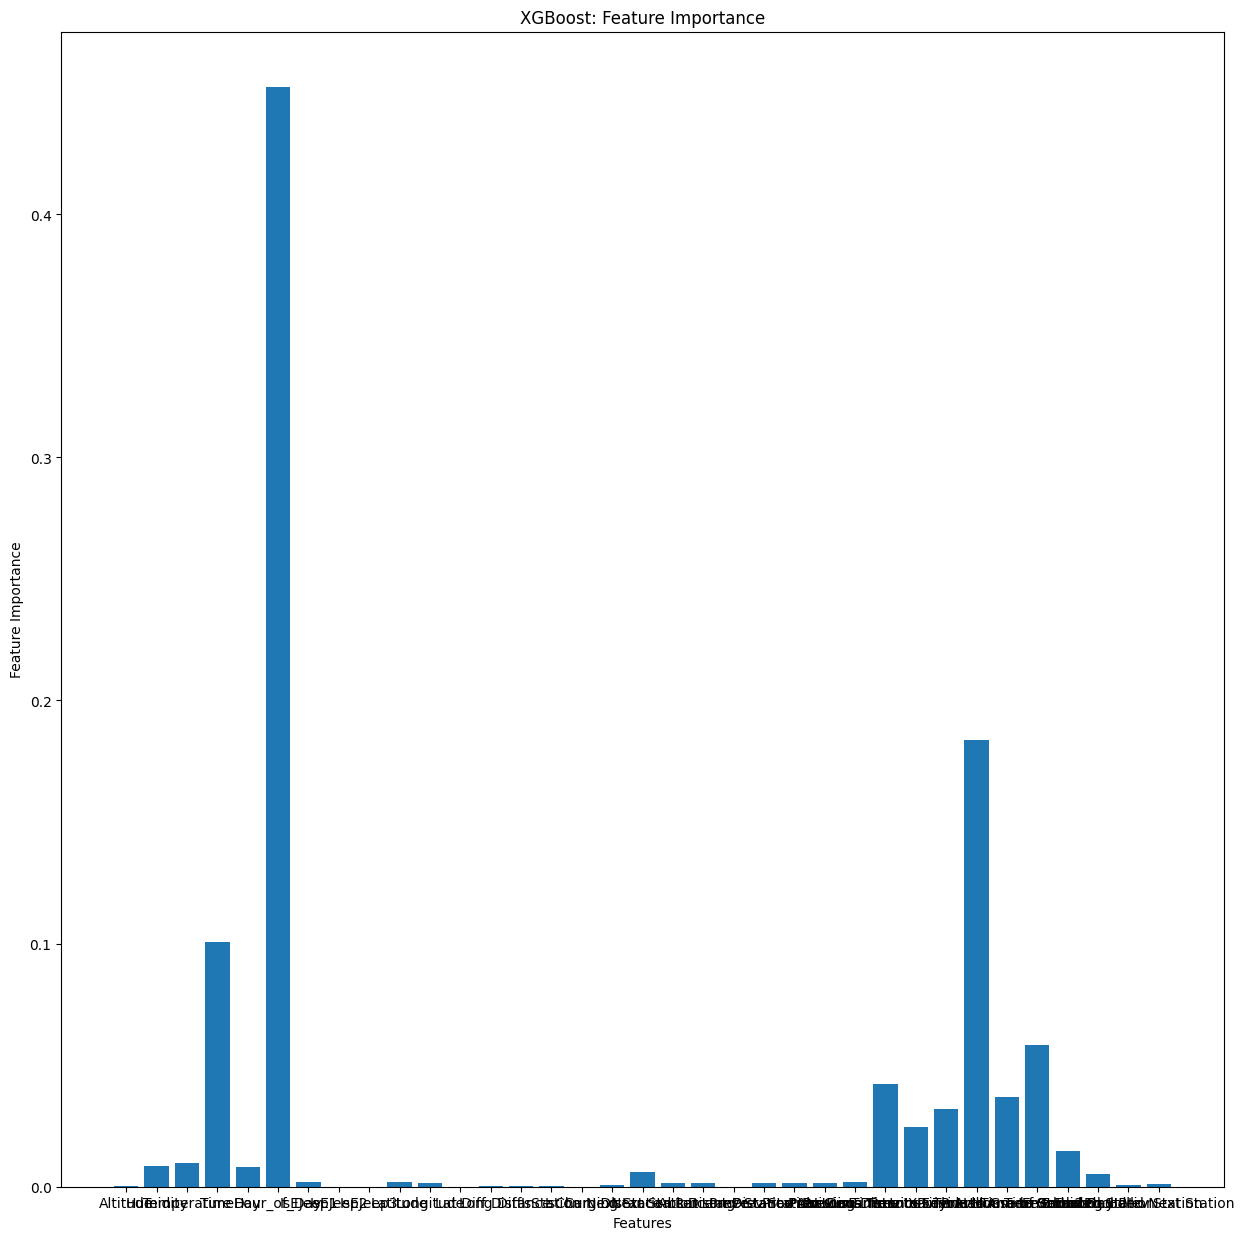

In [72]:
# Check XGBoost Feature importance
# plot feature importance
plt.figure(figsize=(15, 15))
plt.bar(X_train.columns, model_xgb.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('XGBoost: Feature Importance')
plt.show()


<Axes: >

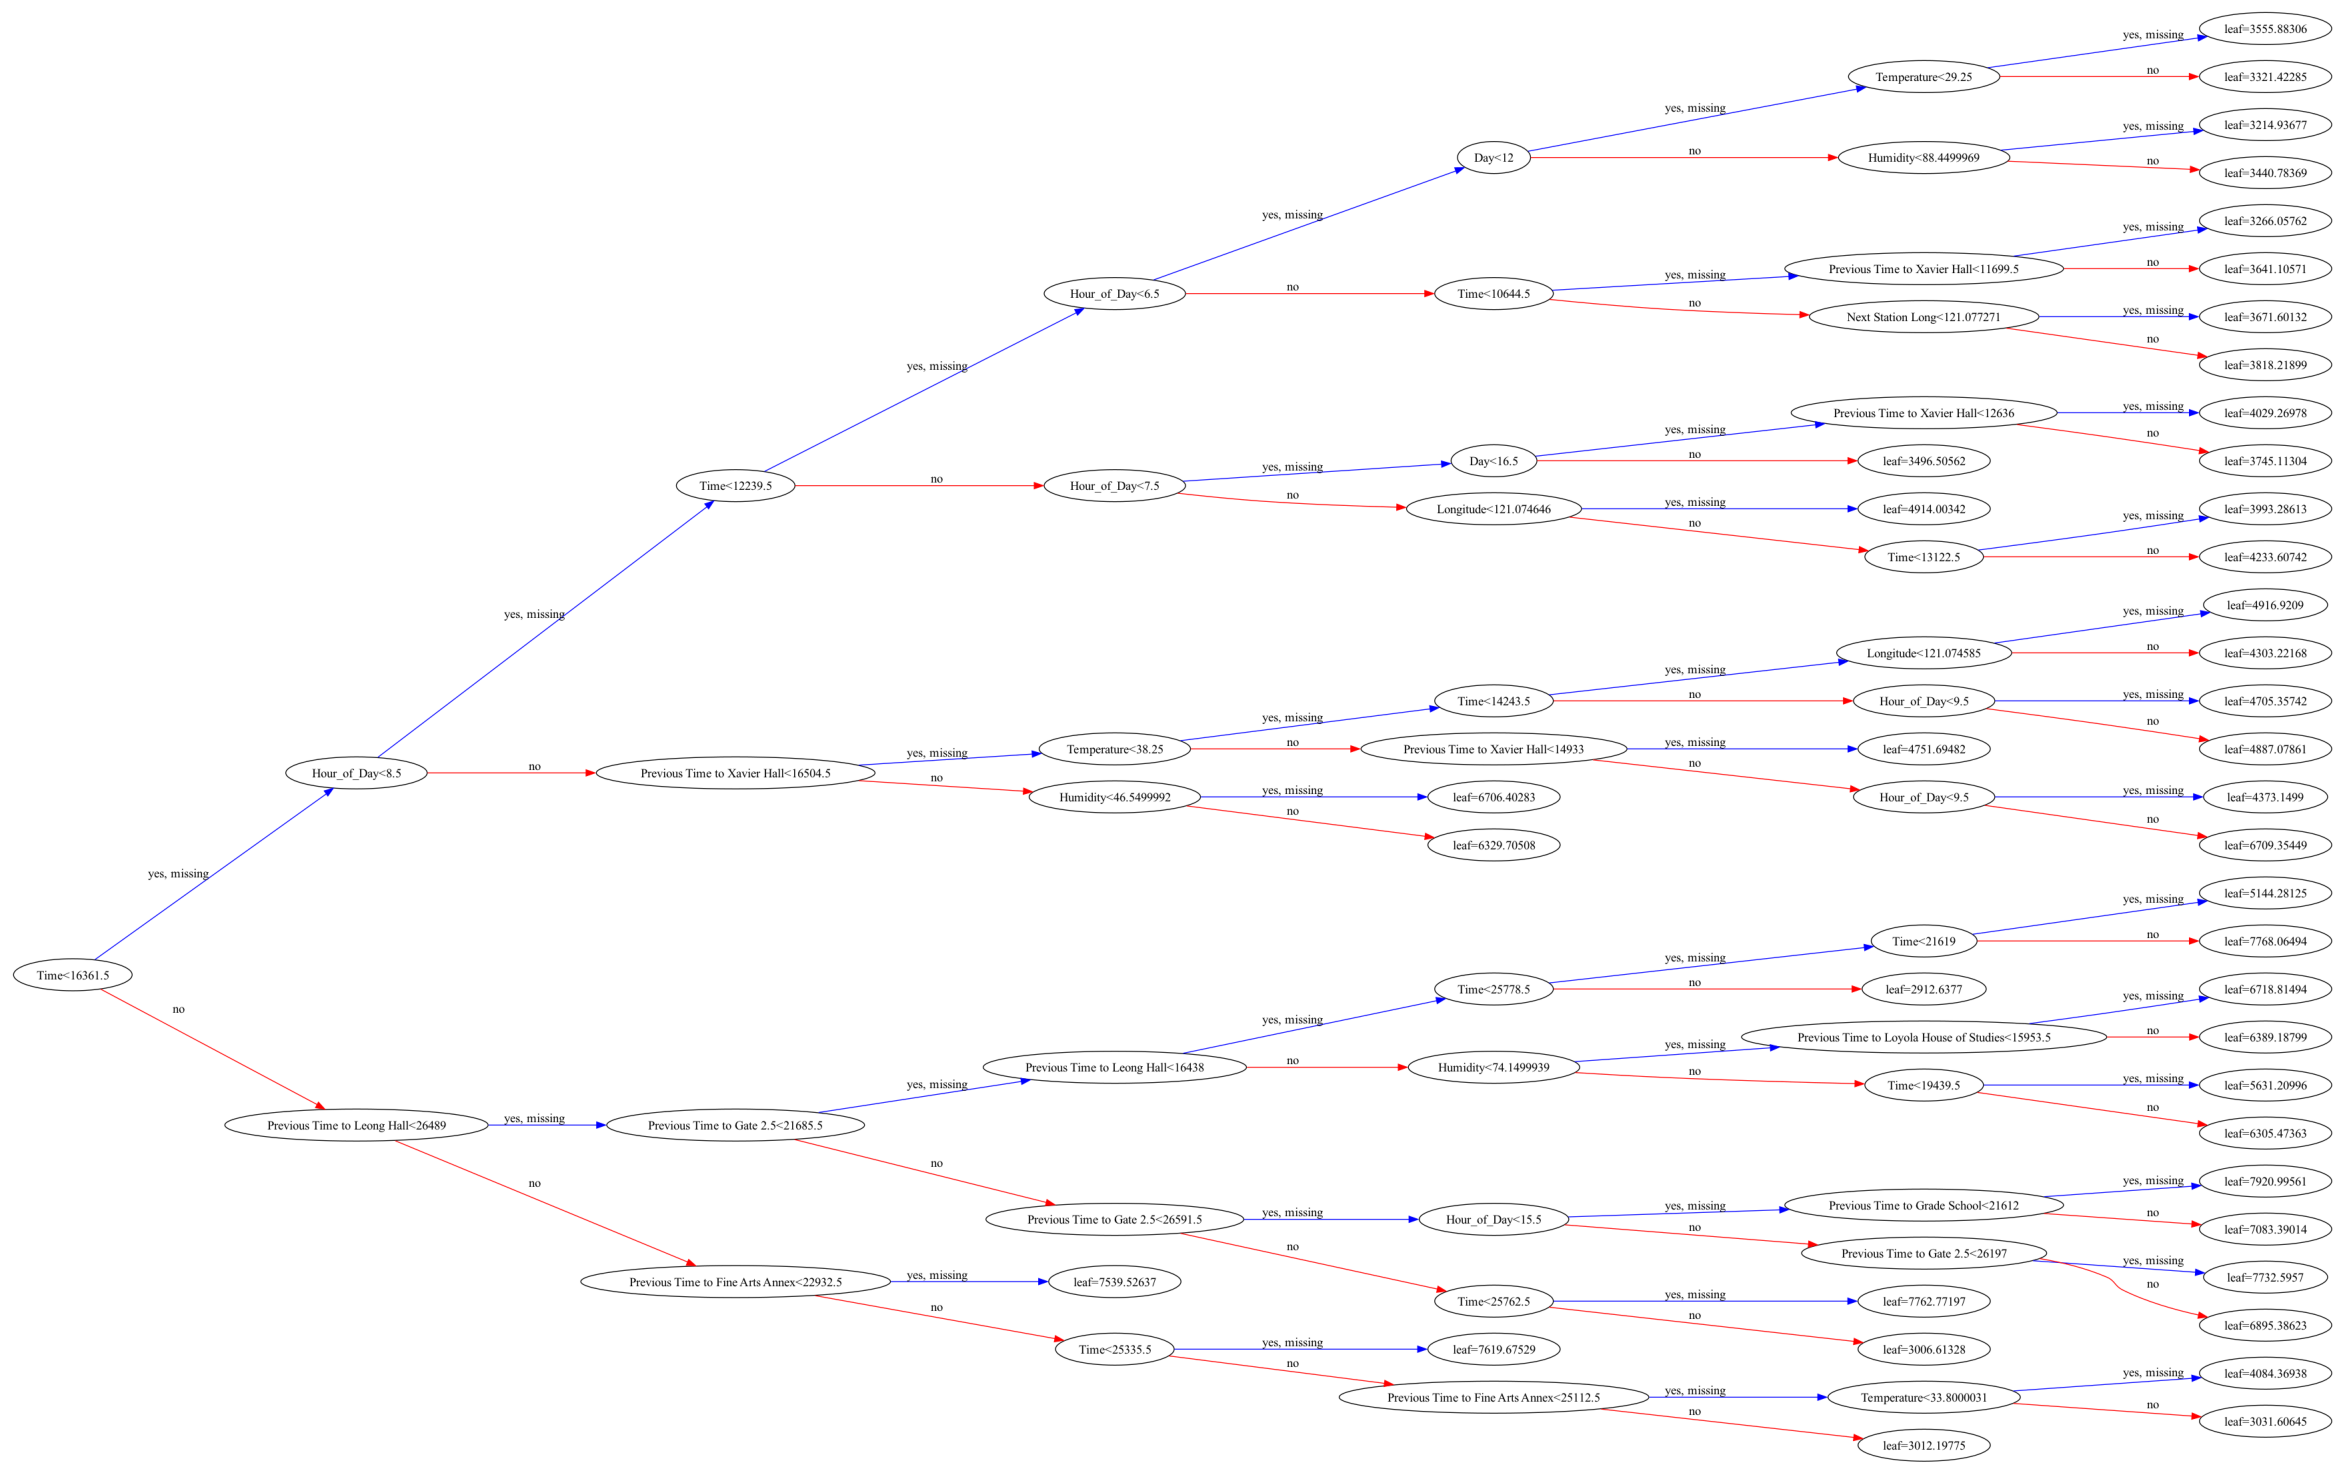

In [103]:
# fig, ax = plt.subplots(figsize=(30, 30))
import xgboost
xgboost.plot_tree(model_xgb, num_trees=1, ax=ax, rankdir='LR', )
# plt.show()


# Linear Regression Part

In [29]:
assert(False)

AssertionError: 

In [86]:
model_lr = LinearRegression()
model_lr.fit(X_train, Y_train)

model_s_lr = LinearRegression()
model_s_lr.fit(Xs_train, Y_train)

LinearRegression()

In [87]:
df_output = pd.DataFrame().reindex_like(Y_train)
df_s_output = pd.DataFrame().reindex_like(Y_train)

In [88]:
def daytimestamp_to_time(val: int) -> str:
    h = val // (24 * 60)
    m_s = val % (24 * 60)
    m = m_s // 60
    s = m_s % 60

    return f'{h:02}:{m:02}:{s:02}'

In [91]:
i = 0

for index, row in X_test.iterrows():
    y_hat = model_lr.predict(row.to_frame().transpose())
    df_output.loc[len(df_output)] = y_hat[0]

df_output

,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall,Next Time to Xavier Hall,IsEJeep1,IsEJeep2,IsEJeep3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
482693,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-5.192513e-13,1.0,0.0
482694,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-5.048184e-13,1.0,0.0
482695,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-5.072609e-13,1.0,0.0
482696,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-5.090373e-13,1.0,0.0


In [92]:
for index, row in Xs_test.iterrows():
    y_hat = model_s_lr.predict(row.to_frame().transpose())
    df_s_output.loc[len(df_s_output)] = y_hat[0]

df_s_output

,Next Time to Fine Arts Annex,Next Time to Loyola House of Studies,Next Time to Grade School,Next Time to Gate 2.5,Next Time to Leong Hall,Next Time to Xavier Hall,IsEJeep1,IsEJeep2,IsEJeep3
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
482693,15622.301539,14924.831221,15822.365085,15293.460109,14858.828837,15235.005924,2.400857e-13,1.0,0.0
482694,15559.146448,14861.820927,15764.883826,15249.423950,14802.529500,15158.555073,2.318701e-13,1.0,0.0
482695,15454.131078,14758.204091,15665.106712,15164.396104,14698.459609,15043.265966,2.240985e-13,1.0,0.0
482696,15394.650005,14701.868831,15610.337574,15112.169982,14638.379933,14977.862324,2.211564e-13,1.0,0.0


In [93]:
df_output.to_csv('Linear Reg Output.csv')
df_s_output.to_csv('Linear Reg Spec Output.csv')

In [97]:
Y_test = Y_test.dropna()
df_output = df_output.dropna()
df_s_output = df_s_output.dropna()

Y_test = Y_test.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])
df_output = df_output.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])
df_s_output = df_s_output.drop(columns=['IsEJeep1', 'IsEJeep2', 'IsEJeep3'])

In [98]:
# Calculating MSE for all columns
rmse = mean_squared_error(Y_test, df_output, squared=False)
rmse_s = mean_squared_error(Y_test, df_s_output, squared=False)

mae = mean_absolute_error(Y_test, df_output)
mae_s = mean_absolute_error(Y_test, df_s_output)

r2 = r2_score(Y_test, df_output)
r2_s = r2_score(Y_test, df_s_output)

print('With Next Time of Arrival in Train Dataset:')
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')
print(f'MAE: {mae}')

6.39358377905157e-11, 4067.34363732951


In [109]:
# print a row of X_test and Y_test
print(X.iloc[300100])
print(Y_test.iloc[100])

Altitude                                       76.400000
Humidity                                       88.599998
Temperature                                    28.700001
Time                                        10641.000000
Day                                            15.000000
Hour_of_Day                                     7.000000
IsEJeep1                                        0.000000
IsEJeep2                                        1.000000
IsEJeep3                                        0.000000
Latitude                                       14.641181
Longitude                                     121.076593
Lat Diff                                        0.000002
Long Diff                                       0.000007
Distance                                        0.840525
IsStation                                       0.000000
IsCharging                                      0.000000
Cum Distance                                  259.892144
Next Station Lat               